# CSC2611 Lab: Word embedding and semantic change
## Part 2 Diachronic word embedding

### Step 1. Download the diachronic word2vec embeddings from the course syllabus page. These embeddings capture historical usage of a small subset of English words over the past century.

In [1]:
import pickle

# the data needs to be manually downloaded to execute the code
with open('data/data.pkl', 'rb') as f:
    data = pickle.load(f)

### Step 2-1. Propose three different methods for measuring degree of semantic change for individual words and report the top 20 most and least changing words in table(s) from each measure.

#### Method 1. Cosine similarity between the vector representation of the word of interest in the first timeslice and in the last timeslice

In [2]:
import numpy as np

# make the list to numpy array
data_E_np = np.asarray(data['E'])

# convert the given 2000*10*300 list of list of vectors to 10*2000*300 list of list of vectors
# (i,j)-th entry: j-th word in the i-th year
data_E_np_year_first = np.swapaxes(data_E_np,0,1)

In [3]:
from sklearn.metrics.pairwise import cosine_similarity

sem_change_1 = []

for changing_sequence_word in data['E']:

    word_in_first_time = np.asarray(changing_sequence_word[0]).reshape(1, -1)
    word_in_last_time = np.asarray(changing_sequence_word[9]).reshape(1, -1)
    
    cos_sim = cosine_similarity(X=word_in_first_time, Y=word_in_last_time)[0][0]
    sem_change_1.append(cos_sim)

In [4]:
most_changing_words = sorted(range(len(sem_change_1)), key=lambda i: sem_change_1[i], reverse=False)
least_changing_words = sorted(range(len(sem_change_1)), key=lambda i: sem_change_1[i], reverse=True)

print("Top 20 most changing word based on the first method:")
count = 0
for i in most_changing_words:
    if np.any(data_E_np_year_first[0][i]) and np.any(data_E_np_year_first[9][i]):
        print(data['w'][i], end = ' ')
        count += 1
    if count > 19:
        break
    
print("\nTop 20 least changing word based on the first method:")
count = 0
for i in least_changing_words:
    if np.any(data_E_np_year_first[0][i]) and np.any(data_E_np_year_first[9][i]):
        print(data['w'][i], end = ' ')
        count += 1
    if count > 19:
        break

Top 20 most changing word based on the first method:
programs objectives computer radio sector goals approach van shri media impact perspective patterns berkeley shift film assessment stanford challenge therapy 
Top 20 least changing word based on the first method:
april june november february years october increase january century months daughter december god september feet week evening door payment miles 

#### Method 2. How much the relationship (as cosine similarity) between the word of interest and each of all the other words has been changed (as cosine similarity between the first timeslice and the last timeslice)

In [5]:
# 2000*2000 matrix
# each vector represent a relationship between a word and all the other words + the word itself
cosim_first = cosine_similarity(data_E_np_year_first[0], data_E_np_year_first[0])
cosim_last = cosine_similarity(data_E_np_year_first[9], data_E_np_year_first[9])

In [6]:
sem_change_2 = []

for i in range(2000):
    sem_change_2.append(cosine_similarity(cosim_first[i].reshape(1, -1), cosim_last[i].reshape(1, -1))[0][0])

In [7]:
most_changing_words_2 = sorted(range(len(sem_change_2)), key=lambda i: sem_change_2[i], reverse=False)
least_changing_words_2 = sorted(range(len(sem_change_2)), key=lambda i: sem_change_2[i], reverse=True)

print("Top 20 most changing word based on the second method:")
count = 0
for i in most_changing_words_2:
    # We want to exclude out-of-vocabulary words represented by vectors of zeros!
    if np.any(data_E_np_year_first[0][i]) and np.any(data_E_np_year_first[9][i]):
        print(data['w'][i], end = ' ')
        count += 1
    if count > 19:
        break
    
print("\nTop 20 least changing word based on the second method:")
count = 0
for i in least_changing_words_2:
    # We want to exclude out-of-vocabulary words represented by vectors of zeros!
    if np.any(data_E_np_year_first[0][i]) and np.any(data_E_np_year_first[9][i]):
        print(data['w'][i], end = ' ')
        count += 1
    if count > 19:
        break

Top 20 most changing word based on the second method:
programs objectives radio approach goals computer signal film impact perspective patterns shift media challenge sector model pattern framework project gap 
Top 20 least changing word based on the second method:
coast november april increase north february surface december quantity nature september east miles january june father evening consideration island explanation 

#### Method 3. How much the relationship between (as cosine similarity) between the word of interest and top 20 nearest neighboring words in the last timeslice has been changed (as cosine similarity between the first timeslice and the last timeslice)

In [8]:
# Top 20 nearest neighbors in the last timeslice based on cosine similarity
# record the cosine similarity between
# each of the 20 neighbors and the word of interest as a vector of size 20

last_closest_words = []
for w in range(len(cosim_last)):
    closest = sorted(range(len(cosim_last[w])), key=lambda i: cosim_last[w][i], reverse=True)
    last_closest_words.append(closest)

In [9]:
last_20_closest_words_in_first = [] # 2000*20 matrix (20 neighboring words per each word)
last_20_closest_words_in_last = []  # 2000*20 matrix (same as above)

for i in range(2000):
    # exclude itself
    word_first = [] # cosine simliarity between 20 neighboring words in the first timeslice
    word_last = []  # cosine simliarity between the same 20 words above in the last timeslice
    for j in range(1,21):
        nei_index = last_closest_words[i][j]
        word_first.append(cosim_first[i][nei_index])
        word_last.append(cosim_last[i][nei_index])
    last_20_closest_words_in_first.append(word_first)
    last_20_closest_words_in_last.append(word_last)

In [10]:
# cosine similarity between
# 1) 20-long vector containing cosine similrarities between the word of interest
# and top 20 closest word in the first timeslice and
# 2) 20-long vector containing cosine similarities between the same 20 word pairs
# but in the last timeslice
# the high the cosine similarity is, the less the semantic change has happend
# across 100 years

sem_change_3 = []

for i in range(2000):
    ith_word_first_time = np.asarray(last_20_closest_words_in_first[i]).reshape(1, -1)
    ith_word_last_time = np.asarray(last_20_closest_words_in_last[i]).reshape(1, -1)
    sem_change_3.append(cosine_similarity(ith_word_first_time, ith_word_last_time)[0][0])

In [11]:
most_changing_words_3 = sorted(range(len(sem_change_3)), key=lambda i: sem_change_3[i], reverse=False)
least_changing_words_3 = sorted(range(len(sem_change_3)), key=lambda i: sem_change_3[i], reverse=True)

print("Top 20 most changing word based on the third method:")
count = 0
for i in most_changing_words_3:
    # We want to exclude out-of-vocabulary words represented by vectors of zeros!
    if np.any(data_E_np_year_first[0][i]) and np.any(data_E_np_year_first[9][i]):
        print(data['w'][i], end = ' ')
        count += 1
    if count > 19:
        break
        
print("\nTop 20 least changing word based on the third method:")
count = 0
for i in least_changing_words_3:
    # We want to exclude out-of-vocabulary words represented by vectors of zeros!
    if np.any(data_E_np_year_first[0][i]) and np.any(data_E_np_year_first[9][i]):
        print(data['w'][i], end = ' ')
        count += 1
    if count > 19:
        break

Top 20 most changing word based on the third method:
objectives radio film signal release programs approach computer media assessment model count focus intelligence intervention impact post memory framework resolution 
Top 20 least changing word based on the third method:
december months days sea june afternoon april coast february father september january july wife nose autumn iowa gentleman dinner ohio 

#### Method 3.1. (Extra) Repeat the same as Method 3 but with the top neighbors in the first timeslice

In [12]:
# Top 20 nearest neighbors in the first timeslice based on cosine similarity
# record the cosine similarity between
# each of the 20 neighbors and the word of interest as a vector of size 20

first_closest_words = []
for w in range(len(cosim_first)):
    closest = sorted(range(len(cosim_first[w])), key=lambda i: cosim_first[w][i], reverse=True)
    first_closest_words.append(closest)

In [13]:
first_20_closest_words_in_first = [] # 2000*20 matrix (20 neighboring words per each word)
first_20_closest_words_in_last = []  # 2000*20 matrix (same as above)

for i in range(2000):
    # exclude itself
    word_first = [] # cosine simliarity between 20 neighboring words in the first timeslice
    word_last = []  # cosine simliarity between the same 20 words above in the last timeslice
    for j in range(1,21):
        nei_index = first_closest_words[i][j]
        word_first.append(cosim_first[i][nei_index])
        word_last.append(cosim_last[i][nei_index])
    first_20_closest_words_in_first.append(word_first)
    first_20_closest_words_in_last.append(word_last)

In [14]:
# cosine similarity between
# 1) 20-long vector containing cosine similrarities between the word of interest
# and top 20 closest word in the first timeslice and
# 2) 20-long vector containing cosine similarities between the same 20 word pairs
# but in the last timeslice
# the high the cosine similarity is, the less the semantic change has happend
# across 100 years

sem_change_3_first = []

for i in range(2000):
    ith_word_first_time = np.asarray(first_20_closest_words_in_first[i]).reshape(1, -1)
    ith_word_last_time = np.asarray(first_20_closest_words_in_last[i]).reshape(1, -1)
    sem_change_3_first.append(cosine_similarity(ith_word_first_time, ith_word_last_time)[0][0])

In [15]:
most_changing_words_3 = sorted(range(len(sem_change_3_first)), key=lambda i: sem_change_3_first[i], reverse=False)
least_changing_words_3 = sorted(range(len(sem_change_3_first)), key=lambda i: sem_change_3_first[i], reverse=True)

print("Top 20 most changing word based on the third method (with the words from the first decade):")
count = 0
for i in most_changing_words_3:
    # We want to exclude out-of-vocabulary words represented by vectors of zeros!
    if np.any(data_E_np_year_first[0][i]) and np.any(data_E_np_year_first[9][i]):
        print(data['w'][i], end = ' ')
        count += 1
    if count > 19:
        break
        
print("\nTop 20 least changing word based on the third method (with the words from the first decade):")
count = 0
for i in least_changing_words_3:
    # We want to exclude out-of-vocabulary words represented by vectors of zeros!
    if np.any(data_E_np_year_first[0][i]) and np.any(data_E_np_year_first[9][i]):
        print(data['w'][i], end = ' ')
        count += 1
    if count > 19:
        break

Top 20 most changing word based on the third method (with the words from the first decade):
approach computer objectives radio sector depression impact perspective shift programs challenge signal film goals lot therapy patterns models framework focus 
Top 20 least changing word based on the third method (with the words from the first decade):
iowa minnesota south december georgia yards days flowers months june indiana obligations evening coast july profits september meaning francisco ohio 

### Step 2-2. Measure the intercorrelations (of semantic change in all words, given the embeddings from Step 1) among the three methods you have proposed and summarize the Pearson correlations in a 3-by-3 table.

In [16]:
from scipy.stats import pearsonr

corr_1_2 = pearsonr(list(sem_change_1), list(sem_change_2))
corr_1_3 = pearsonr(list(sem_change_1), list(sem_change_3))
corr_2_3 = pearsonr(list(sem_change_2), list(sem_change_3))

print(f"Pearson’s correlation coefficient between method 1 and 2:\t {corr_1_2[0]:.2}", f"\tp-value: {corr_1_2[1]:.2}")
print(f"Pearson’s correlation coefficient between method 1 and 3:\t {corr_1_3[0]:.2}", f"\tp-value: {corr_1_3[1]:.2}")
print(f"Pearson’s correlation coefficient between method 2 and 3:\t {corr_2_3[0]:.2}", f"\tp-value: {corr_2_3[1]:.2}")

Pearson’s correlation coefficient between method 1 and 2:	 0.78 	p-value: 0.0
Pearson’s correlation coefficient between method 1 and 3:	 0.6 	p-value: 9.9e-196
Pearson’s correlation coefficient between method 2 and 3:	 0.78 	p-value: 0.0


### Step 3. Propose and justify a procedure for evaluating the accuracy of the methods you have proposed in Step 2, and then evaluate the three methods following this proposed procedure and report Pearson correlations or relevant test statistics.

In [17]:
# evaluate with words that experienced known changes

eval_words = ["sex", "diet", "file", "cell", "address"]

for w in eval_words:
    print(w)
    print("Method 1:", most_changing_words.index(data['w'].index(w)), "th among 2000 words")
    print("Method 2:", most_changing_words_2.index(data['w'].index(w)), "th among 2000 words")
    print("Method 3:", most_changing_words_3.index(data['w'].index(w)), "th among 2000 words\n")

sex
Method 1: 682 th among 2000 words
Method 2: 324 th among 2000 words
Method 3: 255 th among 2000 words

diet
Method 1: 774 th among 2000 words
Method 2: 323 th among 2000 words
Method 3: 159 th among 2000 words

file
Method 1: 27 th among 2000 words
Method 2: 50 th among 2000 words
Method 3: 57 th among 2000 words

cell
Method 1: 506 th among 2000 words
Method 2: 820 th among 2000 words
Method 3: 544 th among 2000 words

address
Method 1: 79 th among 2000 words
Method 2: 63 th among 2000 words
Method 3: 111 th among 2000 words



In [18]:
# words sorted by the degree of disagreement between two methods

degree_disagree_1_3 = []
degree_disagree_1_2 = []
degree_disagree_2_3 = []

for i in range(2000):
    degree_disagree_1_3.append(abs(sem_change_1[i] - sem_change_3[i]))
    degree_disagree_1_2.append(abs(sem_change_1[i] - sem_change_2[i]))
    degree_disagree_2_3.append(abs(sem_change_2[i] - sem_change_3[i]))
    
degree_disagree_1_3_sorted = sorted(range(len(degree_disagree_1_3)), key=lambda i: degree_disagree_1_3[i], reverse=True)
degree_disagree_1_2_sorted = sorted(range(len(degree_disagree_1_2)), key=lambda i: degree_disagree_1_2[i], reverse=True)
degree_disagree_2_3_sorted = sorted(range(len(degree_disagree_2_3)), key=lambda i: degree_disagree_2_3[i], reverse=True)

### Step 4. Extract the top 3 changing words using the best method from Steps 2 and 3. Propose and implement a simple way of detecting the point(s) of semantic change in each word based on its diachronic embedding time course--visualize the time course and the detected change point(s).

In [19]:
# Prepare list of cosine similarity between all word pairs for each timeslice
cosim_all = []
cosim_all.append(cosim_first)
cosim_all.append(cosine_similarity(data_E_np_year_first[1], data_E_np_year_first[1]))
cosim_all.append(cosine_similarity(data_E_np_year_first[2], data_E_np_year_first[2]))
cosim_all.append(cosine_similarity(data_E_np_year_first[3], data_E_np_year_first[3]))
cosim_all.append(cosine_similarity(data_E_np_year_first[4], data_E_np_year_first[4]))
cosim_all.append(cosine_similarity(data_E_np_year_first[5], data_E_np_year_first[5]))
cosim_all.append(cosine_similarity(data_E_np_year_first[6], data_E_np_year_first[6]))
cosim_all.append(cosine_similarity(data_E_np_year_first[7], data_E_np_year_first[7]))
cosim_all.append(cosine_similarity(data_E_np_year_first[8], data_E_np_year_first[8]))
cosim_all.append(cosim_last)

In [20]:
# Only for preliminary analysis
def changing_sequence(word, num_words):
    """
    For the given word and the number of nearest neighboring words,
    prints the changing neighbors and the overlapping neighbors between the two adjacent timeslice
    """
    
    index = data['w'].index(word)
    num_words = num_words+1 # exclude the word itself, which is the nearest word to the word itself
 
    print("\n\nWord: ", data['w'][index])
    for y in range(9):       
        print("\n", end = ' ')
        closest_prev = sorted(range(len(cosim_all[y][index])), key=lambda i: cosim_all[y][index][i], reverse=True)
        closest_after = sorted(range(len(cosim_all[y+1][index])), key=lambda i: cosim_all[y+1][index][i], reverse=True)
        overlap = set(closest_prev[1:num_words]) & set(closest_after[1:num_words])

        # if the word appears in both of the timeslice compared
        if np.any(data_E_np_year_first[y][index]) and np.any(data_E_np_year_first[y+1][index]):
            print("\n", (y*10)+1900, "-", (y*10)+1910, len(overlap), "overlapping neighbors : ")
            for i in overlap:
                print(data['w'][i], end = ' ')
        
        # word does not appear in prev timeslice
        if np.any(data_E_np_year_first[y][index]):
            print("\n", "Top 20 neighbors in", (y*10)+1900, ": ")
            for i in closest_prev[1:num_words]:
                print(data['w'][i], end = ' ')
            
        # word does not appear in the after timeslice
        if np.any(data_E_np_year_first[y+1][index]):
            print("\n", "Top 20 neighbors in", (y*10)+1910, ": ")
            for i in closest_after[1:num_words]:
                print(data['w'][i], end = ' ')

In [21]:
import matplotlib.pyplot as plt
import pandas as pd 

def changing_sequence_graph(word, num_words):
    """
    For the given word and the number of nearest neighboring words,
    plot a graph showing the degree of change happend in each year
    (defined as the number of overlapping neighbors between the last timeslice and the current timeslice, minus 
    the number of overlapping neighbors between the first timeslice and the current timeslice)
    """

    index = data['w'].index(word)
    num_words = num_words+1 # exclude the word itself, which is the nearest word to the word itself
    
    changing_sequence = []
    
    for y in range(0,10):       
        later_closest_words = sorted(range(len(cosim_all[y][index])), key=lambda i: cosim_all[y][index][i], reverse=True)
        num_overlap_first = len(set(first_closest_words[index][1:num_words]) & set(later_closest_words[1:num_words]))
        num_overlap_last = len(set(last_closest_words[index][1:num_words]) & set(later_closest_words[1:num_words]))
        
        changing_sequence.append([y*10+1900, num_overlap_first, num_overlap_last])
  
        # for plotting, convert changing sequence to pandas dataframe
        df = pd.DataFrame(changing_sequence, columns = ['year', 'first', 'last']) 
        
    plt.plot(df['year'], df['first'], label="1900")
    plt.plot(df['year'], df['last'], label="1990")
    plt.ylim(-1,num_words+1)
    plt.xticks(np.arange(1900, 2000, 10))
    plt.title(word, fontsize=25)
    plt.xlabel("year", fontsize=15)
    plt.ylabel("# of overlapping neighbors", fontsize=15)
    plt.legend(fontsize=15)
    plt.show()

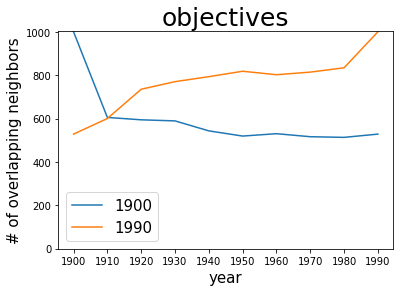

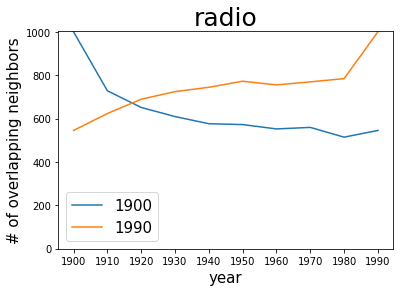

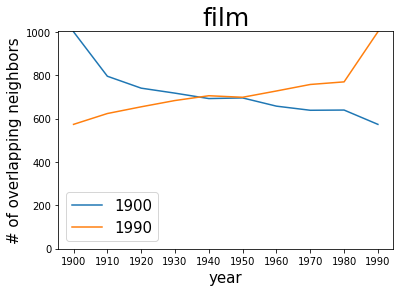

In [22]:
# draw graphs with top 3 changing words: objectives radio film

changing_sequence_graph('objectives', 1000)
changing_sequence_graph('radio', 1000)
changing_sequence_graph('film', 1000)

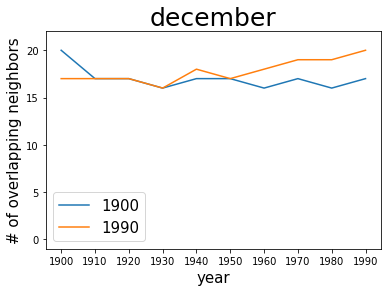

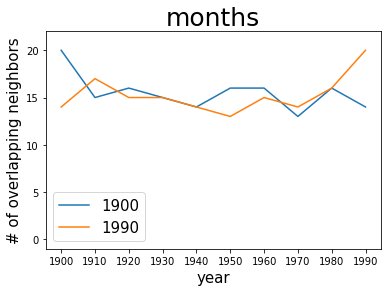

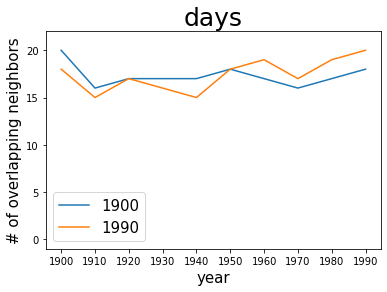

In [23]:
# draw graphs with top 3 stable words: december months days 

changing_sequence_graph('december', 20)
changing_sequence_graph('months', 20)
changing_sequence_graph('days', 20)